# Auto pilot - DNN traniner

This implementation provide an easy way to train a DNN to drive a car in CARLA environment, using imitation leraning.

Sensor configuration:
1x RGB camera 320x240x3

Units:
- steer (float) [-0.7,0.7], default is 0
- throttle(float) [0.0,1.0], default is 0
- brake (float) [0.0,1.0], default is 0

fvilmos
https://github.com/fvilmos

In [1]:
from utils.resize import Resize
from utils.convert_direction import ConvertDirection
from utils.buffer import Buffer

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import matplotlib.gridspec as gridspec
import cv2
import time

import os
import glob
import json
from PIL import Image,ImageFilter

from tensorflow.python.client import device_lib
import numpy as np

USE_GPU=0

if USE_GPU==1:
    def get_available_gpus():
        local_device_protos = device_lib.list_local_devices()
        return [x.name for x in local_device_protos if x.device_type == 'GPU']
    get_available_gpus()

    ## check and set GPU
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    print ("Use CPU...")


Use CPU...


### Start to measure traning time

In [7]:
class TimeCounter(object):
    """counts the elapsed time (min)"""

timecount = TimeCounter()
timecount.tic = time.time()

In [8]:
path='./out/map_uuu_1/*/_info.rec'
val_path='./out/map_u_1/*/_info.rec'
out_net = './ap.h5'

bsize=64
IN_CHANNELS=3
VAL_SPLIT = 0.20
nw, nh = 160,120

NR_OF_PREDICTIONS= 1
SKIP_PREDICTION_SAMPLES=2

IMG_BUFF_LEN = 3
SKIP_IMG_SAMPLES = 2

OUT_ELEMENTS=1

# define the direction of the samples taken from the db [0-neg=in past, 1-pos=in future]
IMG_SAMPLING_DIR = 0
OUT_SAMPLING_DIR = 1

# define the direction of the samples [1-neg=in past, 0-pos=in future]
INV_IN_VALUES = 1
INV_OUT_VALUES = 0


print ("Newrork shape:",nw,nh,IN_CHANNELS)



Newrork shape: 160 120 3


## Load network

In [9]:
print (nw,nh,IN_CHANNELS)

%load_ext autoreload
%autoreload 2
from utils.pilot_model import PilotModel
PilotModel.clean_instance()
#!!!! nh changd to nw
PilotModel(nw,nh,IN_CHANNELS,1,1,nr_of_predictions=NR_OF_PREDICTIONS,img_buff_len=IMG_BUFF_LEN)
model = PilotModel.get_model()
model.summary()


160 120 3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 3, 120, 160, 0                                            
__________________________________________________________________________________________________
cropping3d (Cropping3D)         (None, 3, 60, 160, 3 0           img_in[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 3, 60, 160, 3 0           cropping3d[0][0]                 
__________________________________________________________________________________________________
conv3d_l1 (Conv3D)              (None, 1, 29, 79, 4) 328         lambda[0][0]                     
____________________________________________________________________________________

## Helper functions

In [10]:
# interpolation functions
def val_interp(val,elements=15):
    ret = np.zeros(elements)
    indx = int(np.interp(val,[-0.7,0.7],[0,+(elements-1)]))
    ret[indx]=1
    return ret

def val_de_interp(arr, elements=15):
    val = np.argmax(arr)
    ret = np.interp(val,[0.0,(elements-1)],[-0.7,0.7])
    return ret
   
def img_augment(img):
    
    t_img = img.copy()
    # take a choice regarding augmentation
    ach = np.random.choice([0,1])
    if ach == 0:
        fn_list=[ImageFilter.MaxFilter(size=3),ImageFilter.MinFilter(size=3), ImageFilter.MedianFilter(size=5), ImageFilter.GaussianBlur(radius=2), ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)]   
        t_img = t_img.filter(np.random.choice(fn_list))
    if ach == 1:
        # shift left or right
        # ImageChops.offset(img, -10, 0)
        x0,x1,x2 = 1,0,10
        y0,y1,y2 = 0,1,0
        t_img = t_img.transform(t_img.size, Image.AFFINE, (x0,x1,x2,y0,y1,y2))
    return t_img

# scales input values fom [-0.7,+0.7] to [-1,+1]
def min_max_scaler_m1_p1(val,min_max=[0.7,-0.7]):
    return 2*(val-(min_max[1]))/(min_max[0] - (min_max[1]))-1

# scales input values from [-1,+1] ro [-0.7,+0.7]
def min_max_scaler_m1_p1_inv(val,min_max=[0.7,-0.7]):
    return (val+1)/2*(min_max[0]-min_max[1])+min_max[1]


## Data Loader

Defines the deta structure to be loaded.

Possible strategies:
1. predict based on a single frame, signel output
    {input} RGB frame and/or D-input, direction, velocity => {out} singel dict: throttle,steer,brake
    DataFrame constructed on a single couple of in/ out data. Can be shuffled at item level
    
2. predict based on a single frame, multiple output (Model Predictive Control - like)
    {input} RGB frame and/or D-input, direction, velocity => {out} NR_OF_PREDICTIONS dict: throttle,steer,brake
    DataFrame constructed on a single input and NR_OF_PREDICTIONS.
    Output must contain a NR_OF_PREDICTIONS, based on the real order of the data
3. Mixed shuffle at batch level
    Variant of 2, but shuffle happens at batch level
    
    
Implemented 1,2 - single RGB camera data
    

In [11]:
class ExtDataFrame (tf.keras.utils.Sequence):
    __instance = None
    __data = []
    __all_data = []
    __train_index =[]
    __val_index = []
    __train_len = None
    __validation_len = None
    
    def __init__(self,file, batch_size=16, shuffle=True,subclass='training', val_split=0.2, preprocess=None,nr_of_predictions=1,img_channel=3,filter_fn=[],skip_img_samples=1, img_buff_len=1, use_oversampling=False, oversampling_ratio=0.5,use_augmentation=False, augment_fn=[], augment_ratio=1.0,oversampling_type={type:'passive','sample_limit':200}, skip_prediction_samples=1):
        '''
        Load database and create train batches
        '''
        if ExtDataFrame.__instance == None:
            ExtDataFrame.__instance = self
            ExtDataFrame.__data = ExtDataFrame.get_records(file,filter_fn)
            ExtDataFrame.__data = ExtDataFrame.data_augmentation(use_augmentation=use_augmentation,augment_fn=augment_fn, augment_ratio=augment_ratio)
            data_len = len(ExtDataFrame.__data)
            all_indx = np.array([d['index'] for d in ExtDataFrame.__data])
            print ("data lenght: ", data_len)
            # shuffle all indexes
            if shuffle == True:
                np.random.shuffle(all_indx)
            
            ExtDataFrame.__validation_len = int(data_len * val_split)
            ExtDataFrame.__train_len = data_len - ExtDataFrame.__validation_len

            ExtDataFrame.__train_index = all_indx[0: ExtDataFrame.__train_len:1]
            ExtDataFrame.__val_index = all_indx[ ExtDataFrame.__train_len: ExtDataFrame.__train_len + ExtDataFrame.__validation_len:1]

            if use_oversampling==True:
                if subclass == "training":
                    ExtDataFrame.__train_index = ExtDataFrame.data_oversampling_by_subclass (ExtDataFrame.__train_index,oversampling_ratio,oversampling_type=oversampling_type)
                    ExtDataFrame.__train_len = len(ExtDataFrame.__train_index)

                #else:
                    ExtDataFrame.__val_index = ExtDataFrame.data_oversampling_by_subclass(ExtDataFrame.__val_index,oversampling_ratio,oversampling_type=oversampling_type)
                    ExtDataFrame.__validation_len = len(ExtDataFrame.__val_index)
            
            print ("Subclass data length","train:", ExtDataFrame.__train_len, "validation:", ExtDataFrame.__validation_len)
            
        self.subclass = subclass
        self.train_index = []
        self.val_index = []
        #self.path = path
        self.skip_img_samples = skip_img_samples
        self.skip_prediction_samples= skip_prediction_samples
                
        # load data, split it to train and validation
        self.data = ExtDataFrame.__data
        self.val_len =  ExtDataFrame.__validation_len
        self.train_len =  ExtDataFrame.__train_len
        
        # generate all indexes then slit to training and validation        
        self.train_index =  ExtDataFrame.__train_index
        self.val_index =  ExtDataFrame.__val_index
        
        self.batch_size= batch_size
        self.shuffle = shuffle
        self.prep = preprocess
        
        self.nr_of_predictions = nr_of_predictions
        self.img_channel = img_channel
        
        self.img_buff_len = img_buff_len
        
        self.on_epoch_end()

        
    @staticmethod
    def data_augmentation(use_augmentation=False, augment_fn=[lambda x: True], augment_ratio=1.0):
        new_list =[]
        if use_augmentation == False:
            return ExtDataFrame.__data
        
        # get the data of interest, choose randomly a population, update dataset
        data = [d for d in ExtDataFrame.__data if augment_fn[0](d)]
                        
        population_nr = int(len(data)*augment_ratio)
        new_list = np.random.choice(data,population_nr).tolist()
        [d.update({'augment': True}) for d in new_list]
        
        [new_list.append(d) for d in ExtDataFrame.__data]
        
        print ('use augmentation for {} samples, new {} samples added.Total: {}'.format(len(data),population_nr, len(new_list)))
        return new_list

    @staticmethod
    def data_oversampling_by_subclass(data_ids=[], oversampling_ratio=0.5,oversampling_type=dict()):
        
        HIST_LEN = OUT_ELEMENTS
        if OUT_ELEMENTS==1:
            HIST_LEN = len(np.histogram_bin_edges(data_ids, bins='auto'))

        # determinate majority class
        hist_arr = np.zeros(HIST_LEN)
        sub_ids = []
        
        for id in data_ids:
            # find data by ID
            data = [d for d in ExtDataFrame.__data if d['index']==id]
            
            # get steer value, decode and store
            i_val = val_interp(data[0]['steer'],HIST_LEN)
  
            #print (i_val,data[0]['steer'])
            p_pos = np.argmax(i_val)
            hist_arr[p_pos] += 1
            #print (data)
            xx = data[0]["steer"]
            sub_ids.append({'pos': p_pos, 'id':id, 'data':xx})
        
        # decode majority class value
        maj_class_arr = np.zeros(HIST_LEN)  
        maj_class_arr[np.argmax(hist_arr)] = 1
        maj_class_val = val_de_interp(maj_class_arr,HIST_LEN)
        maj_class_nr = hist_arr[np.argmax(hist_arr)]
                
        # crate a list of scecific sub class IDs, select n samples, apped to subclass list
        new_list = []
        
        print ("Major class NR: ",maj_class_nr, hist_arr)
        for i in range(HIST_LEN):  
            val =[]
            if i == np.argmax(hist_arr) and oversampling_type['type'] != 'passive':
                continue
            [val.append(d['id']) for d in sub_ids if d['pos']== i]
            
            if len(val)>0:
                n_val=[]
                if oversampling_type['type'] == 'passive':
                    print ("Passive oversampling:", oversampling_type['sample_limit'], ' samples/class')
                    n_val = np.random.choice(val,int(oversampling_type['sample_limit'])).tolist()
                    print ("Samples:", len(n_val))
                else:
                    n_val = np.random.choice(val,int((maj_class_nr-hist_arr[i]) * oversampling_ratio)).tolist()
                [new_list.append(d) for d in n_val]

            else:
                print ('0 samples found for index {}'.format(i))
        
        if oversampling_type['type'] != 'passive':
            [new_list.append(x) for x in data_ids]
        
        print ("Oversampled data len:",len(new_list))
        
        return np.array(new_list)
        
    @staticmethod
    def get_records(rec_path='/data/*.rec',filter_fn=[]):
        # get all directories
        dir_data_path = os.path.dirname(rec_path)
        dirs = glob.glob(rec_path,recursive=True)
        dirs.sort()
        print ("data base fond:", dirs)
        # open json
        data_list = []
        
        # for multiple input files, same index ca exist in he databases
        # to avoid conflicts, upate the existing index with new_index - which is unique
        new_index = 0
        for jf in dirs:
            f = open(jf, "r")
            lines = f.readlines()
            f.close()

            # load dicts
            for l in lines:
                dobj = json.loads(l)
                
                # add path
                dobj['rgb_c'] =  os.path.dirname(jf) +"/"+ dobj['rgb_c']
                dobj['depth_c'] =  os.path.dirname(jf) +"/"+ dobj['depth_c']
                
                # update index with a unique number
                dobj['index'] = new_index
                new_index +=1

                # test if img exist
                try:
                    _ = Image.open(dobj['rgb_c'])
                    _ = Image.open(dobj['depth_c'])

                    #filter the data to our interest (i.e. we want just the 'forward' direction)
                    test_ret = []
                    for fn in filter_fn:
                        if fn(dobj) == True:
                            test_ret.append(True)

                    # test if all filters passed the test
                    ExtDataFrame.__all_data.append(dobj)
                    if len(test_ret)>0:
                        data_list.append(dobj)

                except:
                    # no img skipp the data
                    pass

        return data_list
    
    @staticmethod
    def clean_instance():
        ExtDataFrame.__instance = None
        
    @staticmethod
    def get_train_len():
        return ExtDataFrame.__train_len
    
    @staticmethod
    def get_val_len():
        return ExtDataFrame.__validation_len
        
    def __len__(self):
        '''custom len method'''
        if self.subclass is 'training':
            return self.train_len//self.batch_size
        else:
            return self.val_len//self.batch_size
            
    
    def __getitem__(self,indx):
        '''
        Get item by index, based on the selected trategy.
        Additionally will be preprocessed with specific filters.
        '''        
        # get full batch based on the index provided
        if self.subclass is 'training':
            bindx = self.train_index[indx * self.batch_size:(indx + 1) * self.batch_size]
        else:
            bindx = self.val_index[indx * self.batch_size:(indx + 1) * self.batch_size]
        
        # input lists
        # img list
        X = []
        img_arr =[]
        # direction list
        Xd = []
        
        # out lists
        y = []
        y_th = []
        y_j = []
        
        # velocity
        Xv =[]
        
        batch_len = len(bindx)
         
        for i,b in enumerate(bindx):
            
            arr_throttle = np.zeros(self.nr_of_predictions)
            arr_junc = np.zeros(self.nr_of_predictions)
            arr_steer = np.zeros([self.nr_of_predictions,OUT_ELEMENTS])
            arr_brake = np.zeros(self.nr_of_predictions)
            arr_dir = np.zeros(self.img_buff_len)
            arr_velo = np.zeros(self.img_buff_len)
                        
            # get dict by batch index
            val = list(filter(lambda d: d['index'] in [b],ExtDataFrame.__data))[0]
            augment_item = 'augment' in val
            
            # get index in the current array
            i_indx = [i for i,x in enumerate(ExtDataFrame.__data) if x['index']==val['index']][0]
            
            for i,j in enumerate(range(0,self.img_buff_len * self.skip_img_samples, self.skip_img_samples)):
                n_indx = i_indx    

                if IMG_SAMPLING_DIR == 1:
                    if i_indx + j >=len(ExtDataFrame.__data):
                        n_indx = len(ExtDataFrame.__data)
                    else:
                        n_indx = i_indx+j
                else:
                    if i_indx - j < 0:
                        n_indx = i_indx
                    else:
                        n_indx = i_indx-j
                
                n_val = ExtDataFrame.__all_data[n_indx]
                

                # get image and cut png alpha layer
                vimg_path = n_val['rgb_c']
                
                vimg = Image.open(vimg_path)                
                
                # check if augmentation is needed
                if augment_item == True:
                    vimg = img_augment(vimg)
                    
                vimg = np.array(vimg, dtype=np.float32)
                vimg = vimg[:, :, :3]
                            
                # get velocity
                vvelo = n_val['velo']

                # get direction
                vdirection = n_val['direction']
                            
                # apply pre processing functions
                if self.prep:
                    for preprocess in self.prep:
                        vimg, vvelo, vdirection = preprocess([vimg,vvelo,vdirection])
                
                img_arr.append(vimg)
                
                arr_dir[i] = vdirection
                arr_velo[i]= vvelo
                
                       
            # get a set of predicted values
            for inx,j in enumerate(range (0,self.nr_of_predictions * self.skip_prediction_samples, self.skip_prediction_samples)):
                n_indx = i_indx
                
                if OUT_SAMPLING_DIR == 1:
                    if i_indx + j >=len(ExtDataFrame.__data):
                        n_indx = len(ExtDataFrame.__data)
                    else:
                        n_indx = i_indx+j
                else:
                    if i_indx - j < 0:
                        n_indx = i_indx
                    else:
                        n_indx = i_indx-j

                temp_val = ExtDataFrame.__all_data[n_indx]
                arr_throttle[inx] = temp_val['throttle']
                arr_junc[inx] = temp_val['junction']
                                
                if OUT_ELEMENTS == 1:
                    arr_steer[inx] = min_max_scaler_m1_p1(temp_val['steer'])
                else:
                    arr_steer[inx] = val_interp(temp_val['steer'],elements=OUT_ELEMENTS)
                
                arr_brake[inx] = temp_val['brake']
                        
            img_arr = np.array(img_arr)
            
            if INV_IN_VALUES==1:
                #reverse image array
                X.append(img_arr[::-1])

                # append last direction
                Xd.append(arr_dir.tolist()[-1])

                # append last junction info
                Xv.append(arr_velo.tolist()[-1])
            else:
                X.append(img_arr)
                Xd.append(arr_dir.tolist()[1])
                Xv.append(arr_velo.tolist()[1])
                
            img_arr = []
            
            if INV_OUT_VALUES==1:
                y.append(arr_steer[::-1].tolist())
                y_th.append(arr_throttle[::-1].tolist())
                y_j.append(arr_junc[-1].tolist())
            else: 
                y.append(arr_steer.tolist())
                y_th.append(arr_throttle.tolist())
                y_j.append(arr_junc[-1].tolist())
                

        # create name list
        dnames = [] 
        [dnames.append("steer_out_{}".format(i)) for i in range(self.nr_of_predictions)]
        [dnames.append("throttle_out_{}".format(i)) for i in range(self.nr_of_predictions)]
        
        # create values list
        dvals = []
        
        [dvals.append(np.array(y, dtype=np.float32)[:,i,:]) for i in range(self.nr_of_predictions)]
        [dvals.append(np.reshape([np.array(y_th, dtype=np.float32)[:,i]],[batch_len,1])) for i in range(self.nr_of_predictions)]
        
        # join the lists, create a dict
        d_out = dict(zip(dnames,dvals))
               
        return {"img_in": np.array(X, dtype=np.float32), "cmd_in": np.array(Xd,dtype=np.int32),"velo_in": np.array(Xv, dtype=np.float32)}, d_out

            
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.train_index)
            #np.random.shuffle(self.val_index)


### Dataset filtering and oversampling

Usually data sampling leads to unbalanced datasets, which needs preprpocessing for better results.
There are more techniques to improve the situation, the strategy to apply depends from the situation.

Strategies available to improve the situation:
- undersampling - can be acchieved by composing filter over the existing data. i.e. ```filters = [lambda x: True]``` will return all the data or ```[lambda x: True if x['index']% 25 == 0.0 else False]``` - will return verry 25th data sample
- oversampling - can be acheived by adding more times the values for the classes which are in minorty. To do this , use the ```data_oversampling``` function.



```A more complex filter example:
filters = [ lambda x: True if x['steer']<-0.2 else False, 
             lambda x: True if x['index']% 95 == 0.0 else False,
             lambda x: True if x['steer']>0.2 and x['index'] % 2 == 0.0 else False,
             lambda x: True if x['steer']>=0.1 and x['steer']<=0.2 and x['index']% 5 ==0.0 else False,
             lambda x: True if x['steer']<=-0.1 and x['steer']>=-0.2 and x['index']% 7 ==0.0 else False,
           ]```

Note: 
- with undersampling (valid for this implementation), usefull information will be 'ignored'
- oversampling (valid for this implementation), operates on the splitted train / validation datasets, all class samples will adjusted to reach the level of the most dominat class

data base fond: ['./out/map_uuu_1/2021-12-31_17-30-10_right_recovery/_info.rec', './out/map_uuu_1/2021-12-31_17-40-48_left_recovery/_info.rec', './out/map_uuu_1/2021-12-31_17-49-15_forward/_info.rec', './out/map_uuu_1/2022-01-19_21-07-24_right/_info.rec', './out/map_uuu_1/2022-01-19_21-15-55_left/_info.rec']
Total: 11625 zeros: 4342  >0: 3415  <0: 3868
Total: 11625 left samples: 5220  right samples: 4266  forward samples: 2139
 avrg:0.00, std:0.19
 std >0: 0.14505104277970346  std <0: 0.12288041939817193
Nr of outputs: 1


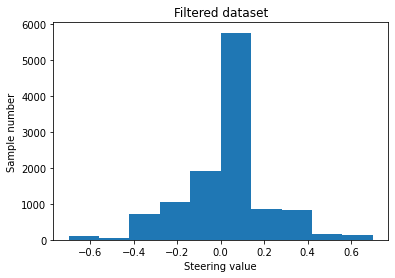

In [12]:
augment_fn = [lambda x: True if (x['steer']<= -0.3 or x['steer']>= 0.3) and x['steer']!= 0.0 else False]

filters = [lambda x: True if x['steer']!=0 or x['index'] % 1 ==0 else False]


#ExtDataFrame.clean_instance()
ret = ExtDataFrame.get_records(path, filters)

key = 'steer'
print ("Total:",len(ret), "zeros:",len([x[key] for x in ret if x[key]==0.0]), " >0:",len([x[key] for x in ret if (x[key]>0.0)]), " <0:",len([x[key] for x in ret if x[key]<0.0]))

print ("Total:",len(ret), "left samples:",len([x['direction'] for x in ret if x['direction']=='left']), " right samples:",len([x['direction'] for x in ret if (x['direction']=='right')]), " forward samples:",len([x['direction'] for x in ret if x['direction']=='forward']))

print (" avrg:{:.2f}, std:{:.2f}".format(np.average([x[key] for x in ret]),np.std([x[key] for x in ret])))
print (" std >0:",np.std([x[key] for x in ret if (x[key]>0.0)]), " std <0:",np.std([x[key] for x in ret if x[key]<0.0]))
print("Nr of outputs:", OUT_ELEMENTS)

x = np.arange(len(ret))
y = np.array([x[key] for x in ret])

plt.title("Filtered dataset")
plt.xlabel("Steering value")
plt.ylabel("Sample number")

if OUT_ELEMENTS!=1:
    print (plt.hist(y,bins=OUT_ELEMENTS))
else:
    plt.hist(y) 
plt.savefig("filtered_data.png")


In [13]:

ExtDataFrame.clean_instance()
train_data_gen = ExtDataFrame(file=path,batch_size=bsize, subclass='training',val_split=VAL_SPLIT, \
                              preprocess=[Resize((nw,nh)),ConvertDirection()], \
                              shuffle=True,nr_of_predictions=NR_OF_PREDICTIONS,img_channel=IN_CHANNELS,\
                              filter_fn=filters,skip_img_samples=SKIP_IMG_SAMPLES, img_buff_len=IMG_BUFF_LEN, \
                              use_oversampling=False, oversampling_ratio=0.1,oversampling_type={'type':'active','sample_limit':400}, use_augmentation=False,augment_fn=augment_fn, augment_ratio=0.4)

test_data_gen = ExtDataFrame(file=path,batch_size=bsize, subclass='validation', val_split=VAL_SPLIT, \
                             preprocess=[Resize((nw,nh)),ConvertDirection()], \
                             shuffle=True, nr_of_predictions=NR_OF_PREDICTIONS, img_channel=IN_CHANNELS, \
                             filter_fn=filters,skip_img_samples=SKIP_IMG_SAMPLES,img_buff_len=IMG_BUFF_LEN, \
                             use_oversampling=True, oversampling_ratio=0.7,oversampling_type={'type':'passive','sample_limit':400},use_augmentation=True)


print ("New train lenght:",train_data_gen.get_train_len(), "New val lenght:",train_data_gen.get_val_len())

data base fond: ['./out/map_uuu_1/2021-12-31_17-30-10_right_recovery/_info.rec', './out/map_uuu_1/2021-12-31_17-40-48_left_recovery/_info.rec', './out/map_uuu_1/2021-12-31_17-49-15_forward/_info.rec', './out/map_uuu_1/2022-01-19_21-07-24_right/_info.rec', './out/map_uuu_1/2022-01-19_21-15-55_left/_info.rec']
data lenght:  11625
Subclass data length train: 9300 validation: 2325
New train lenght: 9300 New val lenght: 2325


9300 9300 2325


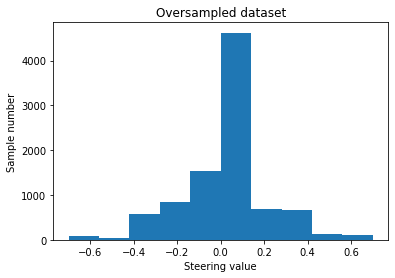

In [14]:
indx_train = train_data_gen.train_index
len_train = len(train_data_gen.train_index)
data = train_data_gen.data

print (len_train,train_data_gen.train_len,test_data_gen.get_val_len())

data_train = []
for indx in indx_train:
    val = list(filter(lambda d: d['index'] in [indx],data))[0]
    data_train.append(val)

key = 'steer'
x = np.arange(len_train)

if OUT_ELEMENTS!=1:
    y = np.array([val_de_interp(val_interp(x[key],elements=OUT_ELEMENTS),elements=OUT_ELEMENTS) for x in data_train])
else:
    y = np.array([x[key] for x in data_train])


plt.title("Oversampled dataset")
plt.xlabel("Steering value")
plt.ylabel("Sample number")
if OUT_ELEMENTS!=1:
    plt.hist(y,bins=OUT_ELEMENTS)
else:
    plt.hist(y)
plt.savefig("oversampled_data.png")

batch_shapes: (120, 160, 3) (1,) (1,)
[2 0 2 0 2 2 0 1 0 2 0 2 2 2 2 0 1 0 0 2 1 0 0 1 0 0 0 1 2 1 2 0 2 0 2 0 0
 0 2 0 0 2 0 2 0 2 2 0 0 2 1 0 1 2 0 0 0 2 0 0 0 2 0 2]
[2 0 2 0 2 2 0 1 0 2 0 2 2 2 2 0 1 0 0 2 1 0 0 1 0 0 0 1 2 1 2 0 2 0 2 0 0
 0 2 0 0 2 0 2 0 2 2 0 0 2 1 0 1 2 0 0 0 2 0 0 0 2 0 2]
[2 0 2 0 2 2 0 1 0 2 0 2 2 2 2 0 1 0 0 2 1 0 0 1 0 0 0 1 2 1 2 0 2 0 2 0 0
 0 2 0 0 2 0 2 0 2 2 0 0 2 1 0 1 2 0 0 0 2 0 0 0 2 0 2]


<Figure size 432x288 with 0 Axes>

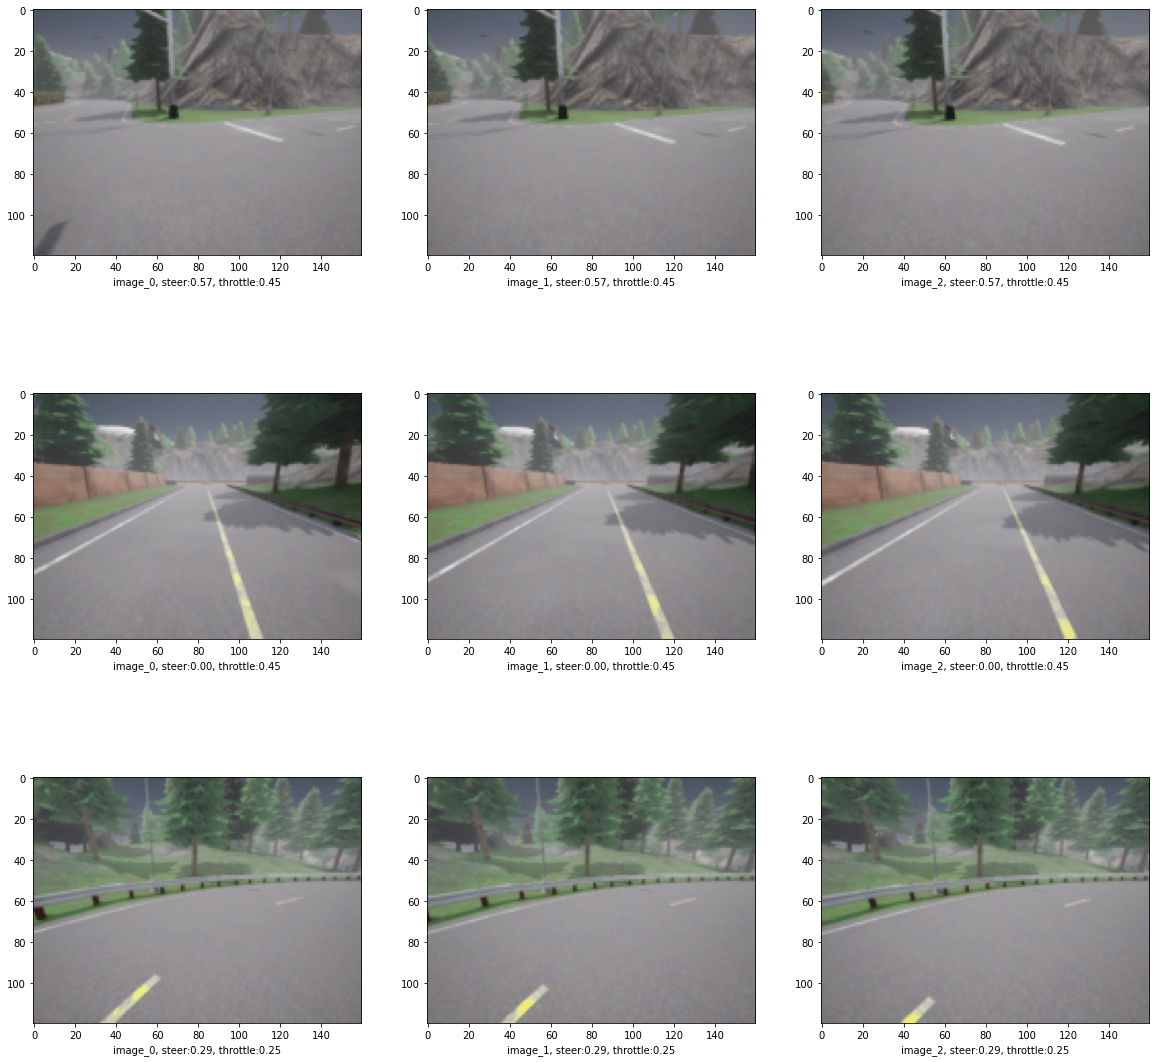

In [15]:
sample = test_data_gen[7]
sample_indx = 0

print ("batch_shapes:", sample[0]['img_in'][sample_indx][0].shape,sample[1]['steer_out_0'][sample_indx].shape, sample[1]['throttle_out_0'][sample_indx].shape)

DISPLAY_COLS=IMG_BUFF_LEN
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=DISPLAY_COLS, nrows=IMG_BUFF_LEN, figure=fig)
fig = plt.figure(figsize=(20, 20))

for j in range(3):
    if OUT_ELEMENTS!=1:
        steer0 = val_de_interp(sample[1]['steer_out_0'][j])
        steer1 = val_de_interp(sample[1]['steer_out_1'][j])
        steer2 = val_de_interp(sample[1]['steer_out_2'][j])
        steer_arr = [steer0,steer1,steer2]
    else:
        steer0 = sample[1]['steer_out_0'][j][0]
        steer_arr = [steer0,steer0,steer0]

    throttle = sample[1]['throttle_out_0'][j][0]
    print (sample[0]['cmd_in'])
    for i in range(IMG_BUFF_LEN):
        subplot = fig.add_subplot(spec[j,i])
        subplot.set_xlabel('image_{}, steer:{:,.2f}, throttle:{:,.2f}'.format(i,steer_arr[i],throttle))
        subplot.imshow(sample[0]['img_in'][j][i]/255.0)

## Train the model

In [16]:
epochs=100

# Comput traning validation steps
train_steps = train_data_gen.get_train_len() // bsize
val_steps = test_data_gen.get_val_len() // bsize

print (bsize, train_steps,val_steps)

checkpoint = ModelCheckpoint(filepath=out_net, verbose=1, save_best_only=True,save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=3, verbose=1, mode='auto')

hist = model.fit(x=train_data_gen,validation_data=test_data_gen,validation_steps=val_steps, steps_per_epoch=train_steps, epochs=epochs, verbose=1, callbacks=[checkpoint,early_stop])


64 145 36
Epoch 1/100
145/145 [==============================] - ETA: 0s - loss: 0.3553 - steer_out_0_loss: 0.3554 - throttle_out_0_loss: 0.3551 - steer_out_0_mae: 0.3554 - throttle_out_0_mae: 0.3551
Epoch 00001: val_loss improved from inf to 0.20482, saving model to ./ap.h5
145/145 [==============================] - 300s 2s/step - loss: 0.3553 - steer_out_0_loss: 0.3554 - throttle_out_0_loss: 0.3551 - steer_out_0_mae: 0.3554 - throttle_out_0_mae: 0.3551 - val_loss: 0.2048 - val_steer_out_0_loss: 0.2081 - val_throttle_out_0_loss: 0.1428 - val_steer_out_0_mae: 0.2081 - val_throttle_out_0_mae: 0.1428
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 0.2003 - steer_out_0_loss: 0.2007 - throttle_out_0_loss: 0.1935 - steer_out_0_mae: 0.2007 - throttle_out_0_mae: 0.1935
Epoch 00002: val_loss improved from 0.20482 to 0.16102, saving model to ./ap.h5
145/145 [==============================] - 296s 2s/step - loss: 0.2003 - steer_out_0_loss: 0.2007 - throttle_out_0_loss: 0.1

min training loss: 0.078 min val loss: 0.068 min val steer loss: 0.081


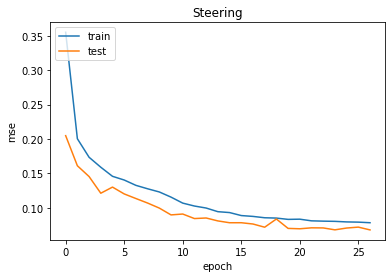

In [17]:
min_tr_loss=min(hist.history['loss'])
min_val_loss=min(hist.history['val_loss'])
min_val_steer_loss=min(hist.history['steer_out_0_loss'])

print ("min training loss: {:.03f}".format(min_tr_loss),"min val loss: {:.03f}".format(min_val_loss), "min val steer loss: {:.03f}".format(min_val_steer_loss))


# print (lab)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Steering')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()


## Test the trained model

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sb

class MDConfusionMatrix():
    def __init__(self,shape=9):
        self.cfm = np.zeros([shape,shape])
        
    def add_sample(self, yr=[],yp=[], total_sample=1):
        
        # get positions
        r_pos = np.argmax(yr)
        p_pos = np.argmax(yp)
        
        self.cfm[p_pos,r_pos] += 1
        return self.cfm / total_sample
    
    def get_cfm(self,total_sample=1):
        return self.cfm/total_sample


    
ExtDataFrame.clean_instance()
filters = [lambda x:True]
test_data_gen = ExtDataFrame(file=val_path,batch_size=bsize, subclass='validation', val_split=1.0, \
                             preprocess=[Resize((nw,nh)),ConvertDirection()], \
                             shuffle=True, nr_of_predictions=NR_OF_PREDICTIONS, img_channel=IN_CHANNELS, filter_fn=filters,skip_img_samples=SKIP_IMG_SAMPLES,img_buff_len=IMG_BUFF_LEN)


# create confusion matrix    
mdcfm = MDConfusionMatrix(OUT_ELEMENTS)


# load model
model.load_weights(out_net)

# load data
mdcfm = MDConfusionMatrix(OUT_ELEMENTS)

sample = test_data_gen[1]

yy,yyr,total_accu = [],[],[]
tp, tn, fp, fn= [],[],[],[]
for j,sample in enumerate(test_data_gen):
    val = []
    for i in range(bsize):
        
        key = 'steer_out_0'
        y = sample[1][key][i]
        
        img = sample[0]['img_in'][i]       
        
        direction = np.array([sample[0]['cmd_in'][i]])
        velo = np.array([sample[0]['velo_in'][i]])

        ret = model.predict({"img_in":img[None,:,:,:],"cmd_in": direction, "velo_in": velo})
        steer_val = ret[key][0]

        if OUT_ELEMENTS !=1:
            p_arr = np.zeros(OUT_ELEMENTS)
            p_pos = np.argmax(steer_val)
            p_arr[p_pos] = 1
            steer_out = val_de_interp(steer_val,OUT_ELEMENTS)
            steer_r = val_de_interp(y,OUT_ELEMENTS)
            mdcfm.add_sample(y,p_arr)

            if np.round(steer_out,2) == np.round(steer_r,2):
                val.append(1)
            
        else:
            steer_out = min_max_scaler_m1_p1(steer_val)
            steer_r = y
            
        yy.append(np.round(steer_out,2))
        yyr.append( np.round(steer_r,2))
        
        if abs(steer_out - steer_r)<=0.05:
                val.append(1)
            
    accu = len(val)/bsize
    
    # True positives/ (True positives + True negatives)
    total_accu.append(accu)
    print ("Steer total tests:",bsize, "index:",j, "detections:",len(val), 'accuracy:',accu,'%')
print ("Average:{:.2f}%".format(np.average(np.array(total_accu))))


data base fond: ['./out/map_u_1/2021-12-31_17-30-10_right_recovery/_info.rec', './out/map_u_1/2021-12-31_17-40-48_left_recovery/_info.rec', './out/map_u_1/2021-12-31_17-49-15_forward/_info.rec', './out/map_u_1/2022-01-01_14-51-19_left_normal/_info.rec', './out/map_u_1/2022-01-01_14-58-08_right_normal/_info.rec']
data lenght:  10258
Subclass data length train: 0 validation: 10258
Steer total tests: 64 index: 0 detections: 22 accuracy: 0.34375 %
Steer total tests: 64 index: 1 detections: 29 accuracy: 0.453125 %
Steer total tests: 64 index: 2 detections: 34 accuracy: 0.53125 %
Steer total tests: 64 index: 3 detections: 37 accuracy: 0.578125 %
Steer total tests: 64 index: 4 detections: 33 accuracy: 0.515625 %
Steer total tests: 64 index: 5 detections: 22 accuracy: 0.34375 %
Steer total tests: 64 index: 6 detections: 22 accuracy: 0.34375 %
Steer total tests: 64 index: 7 detections: 25 accuracy: 0.390625 %
Steer total tests: 64 index: 8 detections: 25 accuracy: 0.390625 %
Steer total tests: 

In [23]:
if OUT_ELEMENTS!=1:
    cfm_val = mdcfm.get_cfm(total_sample=1)
    sb.heatmap(cfm_val,annot=True,xticklabels=np.arange(OUT_ELEMENTS)+1, yticklabels=np.arange(OUT_ELEMENTS)+1,fmt='.0f', cmap='Blues')
else:
    pass

In [24]:
!date

marți 8 februarie 2022, 18:14:23 +0200


In [25]:
if OUT_ELEMENTS!=1:
    tp = np.diag(cfm_val)
    fp = np.sum(cfm_val, axis=0) - np.diag(cfm_val)
    fn = np.sum(cfm_val, axis=1) - np.diag(cfm_val)
    tn = np.sum(cfm_val) - (fp+fn+tp)
    print ("TP:{}, TN:{}, FP:{}, FN:{}".format(np.sum(tp),np.sum(tn),np.sum(fp),np.sum(fn)))
    recall = np.sum(tp)/np.sum((tp+fn))
    precision = np.sum(tn)/np.sum((tn+fp))
    pos_pred_val = np.sum(tp)/np.sum((tp+fp))
    neg_pred_val = np.sum(tn)/np.sum((tn+fn))
    accur = np.sum((tp+tn))/np.sum((tp+tn+fp+fn))
    f1_score = 2*(precision*recall)/(precision+recall)

    print ("accuacy:{:.3f}, f1_score:{:.3f}".format(accur,f1_score))
    print ("Execution time [min]: {:.3f}".format((time.time() - timecount.tic)/60))   
else:
    pass

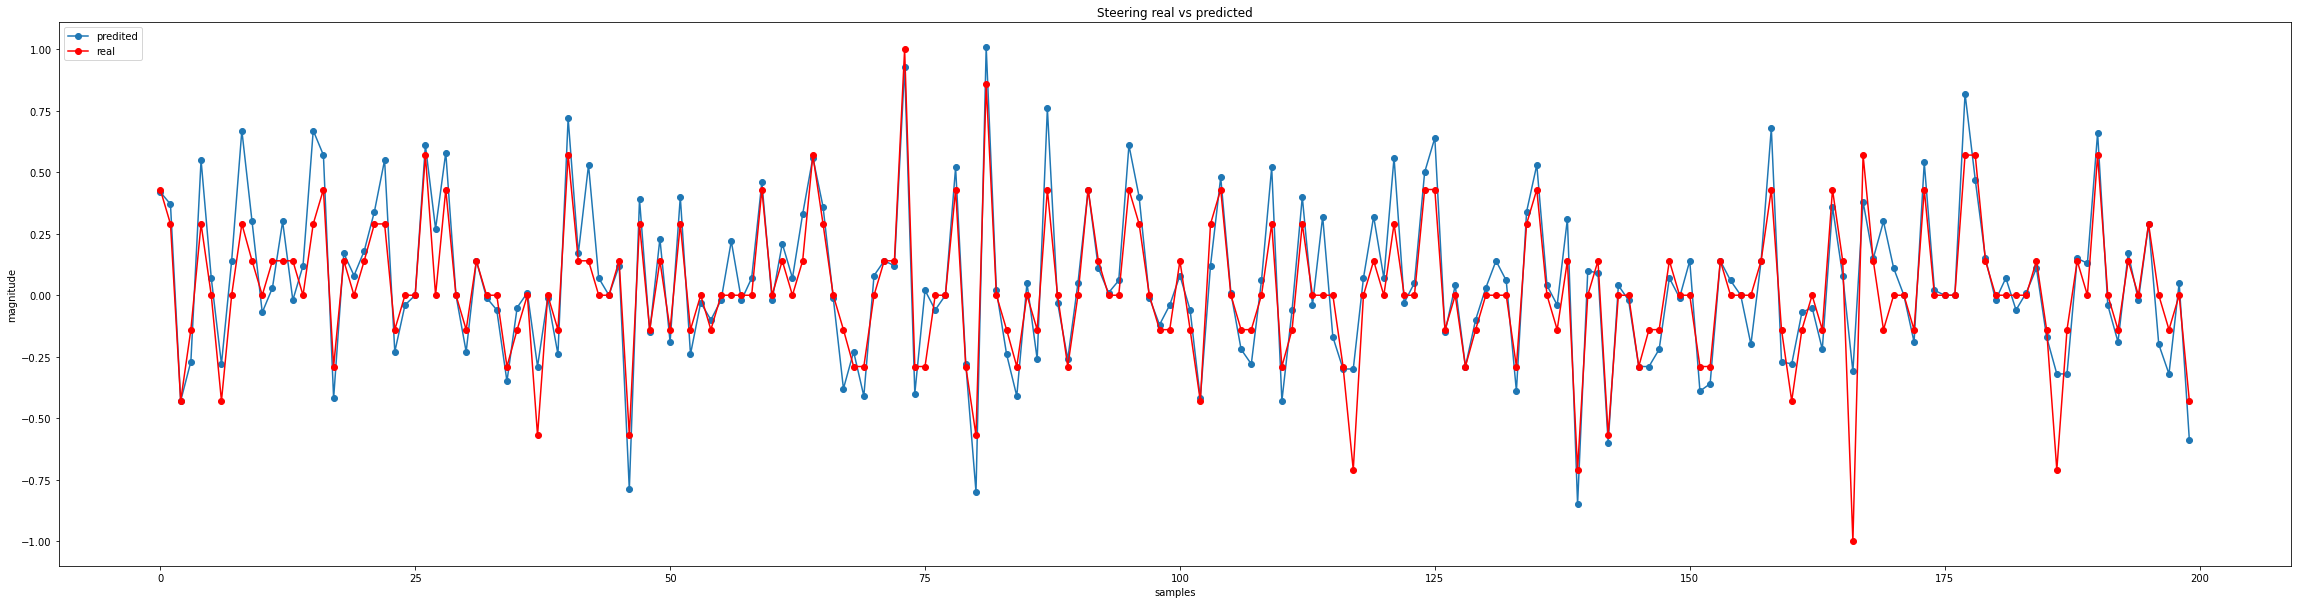

In [27]:
def mavr(data, win=1):
    return np.convolve(data, np.ones(win), 'valid') / win

a = 500

fig = plt.figure(figsize=(40, 10))
plt.plot(mavr(np.array(yy[a:200+a]).T[0]), marker='o')
plt.plot(mavr(np.array(yyr[a:200+a]).T[0]),marker='o',c='r')
plt.title('Steering real vs predicted')
plt.ylabel('magnitude')
plt.xlabel('samples')
plt.legend(['predited','real'], loc='upper left')
plt.savefig('real_vs_pred.png')
plt.show()
